 # LIBERO Rollout SR+Speed Benchmark for MiniVLA + `MiniVLAFastPath`



 This notebook runs LIBERO rollout benchmarks for MiniVLA models.



 **Usage examples:**

 - Run one rollout (default configuration)

 - Run 5 rollouts on task 0, with compiled LLM

 - Evaluate first 8 tasks, 1 rollout each

 ## Setup and Imports

In [ ]:
import os

# Keep these as early as possible for offscreen mujoco + prismatic load.
os.environ.setdefault("PRISMATIC_DATA_ROOT", "")
os.environ.setdefault("MUJOCO_GL", "egl")
os.environ.setdefault("PYOPENGL_PLATFORM", "egl")
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "2")


'false'

In [2]:
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import torch
import tqdm
import sys
sys.path.append("/mnt/scratch/aagouzoul/ovla/openvla-mini")
from libero.libero import benchmark

from experiments.robot.libero.libero_utils import (
    get_libero_dummy_action,
    get_libero_env,
    get_libero_image,
    quat2axisangle,
    save_rollout_video,
)
from experiments.robot.robot_utils import (
    get_image_resize_size,
    get_model,
    invert_gripper_action,
    normalize_gripper_action,
    set_seed_everywhere,
)
from experiments.specdec.minivla_fastpath import MiniVLAFastPath


2025-12-22 00:35:41.125637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-22 00:35:41.128724: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-22 00:35:41.160246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-22 00:35:41.160286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-22 00:35:41.161995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

 ## Helper Functions

In [3]:
def _select_unnorm_key(model, desired: str) -> str:
    """Match common repo logic for picking an available unnorm key."""
    if not hasattr(model, "norm_stats") or not isinstance(getattr(model, "norm_stats"), dict):
        return desired
    if desired in model.norm_stats:
        return desired
    if f"{desired}_no_noops" in model.norm_stats:
        return f"{desired}_no_noops"
    if desired.replace("_no_noops", "") in model.norm_stats:
        return desired.replace("_no_noops", "")
    # Fallback to first key to avoid crashing in quick benchmarks.
    # print in that case
    first_key = next(iter(model.norm_stats.keys()))
    print(f"WARNING: No unnorm key found for {desired}, using first available key: {first_key}")
    return first_key


In [4]:
def _max_steps_for_suite(task_suite_name: str) -> int:
    if task_suite_name == "libero_spatial":
        return 220
    if task_suite_name == "libero_object":
        return 280
    if task_suite_name == "libero_goal":
        return 300
    if task_suite_name == "libero_10":
        return 520
    if task_suite_name == "libero_90":
        return 400
    # Safe-ish fallback.
    return 400


In [5]:
def _summarize_ms(xs: List[float]) -> Dict[str, float]:
    if len(xs) == 0:
        return {"n": 0}
    arr = np.asarray(xs, dtype=np.float64)
    return {
        "n": float(arr.size),
        "mean_ms": float(arr.mean()),
        "std_ms": float(arr.std()),
        "min_ms": float(arr.min()),
        "p50_ms": float(np.percentile(arr, 50)),
        "p90_ms": float(np.percentile(arr, 90)),
        "p95_ms": float(np.percentile(arr, 95)),
        "max_ms": float(arr.max()),
        "hz": float(1000.0 / arr.mean()) if arr.mean() > 0 else float("nan"),
    }


 ## Configuration

In [6]:
@dataclass
class EvalConfig:
    # Model
    model_family: str = "prismatic"
    hf_token: Union[str, Path] = Path(".hf_token")
    pretrained_checkpoint: Union[str, Path] = "Stanford-ILIAD/minivla-libero90-prismatic"
    center_crop: bool = True

    # LIBERO
    task_suite_name: str = "libero_90"
    task_id: int = 0
    num_tasks: int = 1
    num_trials_per_task: int = 1
    num_steps_wait: int = 10
    max_steps_override: Optional[int] = None
    seed: int = 7

    # FastPath
    use_fastpath: bool = True
    compile_llm: bool = False
    compile_vision: bool = False
    compile_mode: str = "default"
    compile_mode_vision: Optional[str] = None  # if None, uses compile_mode; otherwise independent
    warmup_policy_calls: int = 1  # warmup calls per task before timing (helps compiled steady-state)

    # Logging / stats
    show_progress: bool = True
    save_video: bool = False  # Save a local MP4 replay using `save_rollout_video` (no wandb).


 ## Run Benchmark

In [7]:
def run(cfg: EvalConfig) -> None:
    assert cfg.model_family == "prismatic", "This benchmark is for MiniVLA (prismatic) only."
    assert cfg.num_trials_per_task >= 1
    assert cfg.num_tasks >= 1

    set_seed_everywhere(cfg.seed)

    # Load model
    cfg.unnorm_key = cfg.task_suite_name  # expected by `get_model` helpers in this repo
    model = get_model(cfg)
    cfg.unnorm_key = _select_unnorm_key(model, cfg.task_suite_name)

    resize_size = get_image_resize_size(cfg)
    env_resolution = resize_size  # matches `run_libero_eval.py` for prismatic

    # Prepare task suite
    benchmark_dict = benchmark.get_benchmark_dict()
    task_suite = benchmark_dict[cfg.task_suite_name]()
    n_tasks = task_suite.n_tasks
    task_ids = list(range(cfg.task_id, min(cfg.task_id + cfg.num_tasks, n_tasks)))

    # Initialize fastpath once (keeps compilation one-time); update instruction per-task.
    fast: Optional[MiniVLAFastPath] = None

    total_episodes = 0
    total_successes = 0
    all_policy_gpu_ms: List[float] = []
    all_policy_wall_ms: List[float] = []

    # CUDA timing helpers
    use_cuda_events = torch.cuda.is_available()
    start_ev = torch.cuda.Event(enable_timing=True) if use_cuda_events else None
    end_ev = torch.cuda.Event(enable_timing=True) if use_cuda_events else None

    # Match `run_libero_eval.py` style: tqdm over tasks AND tqdm over trials-per-task.
    for task_id in tqdm.tqdm(task_ids, desc=f"Tasks({cfg.task_suite_name})", disable=not cfg.show_progress):
        task = task_suite.get_task(task_id)
        env, task_description = get_libero_env(task, cfg.model_family, resolution=env_resolution)
        initial_states = task_suite.get_task_init_states(task_id)

        # Per-task fastpath update (instruction usually constant throughout rollout).
        if cfg.use_fastpath:
            if fast is None:
                vision_mode = cfg.compile_mode_vision if cfg.compile_mode_vision is not None else cfg.compile_mode

                fast = MiniVLAFastPath(
                    model=model,
                    instruction=task_description,
                    unnorm_key=cfg.unnorm_key,
                    center_crop=cfg.center_crop,
                    compile_llm=cfg.compile_llm,
                    compile_mode=cfg.compile_mode, # LLM mode / vision default
                    compile_vision=cfg.compile_vision,
                    compile_mode_vision=vision_mode,
                )
            else:
                fast.set_instruction(task_description)

        max_steps = cfg.max_steps_override if cfg.max_steps_override is not None else _max_steps_for_suite(cfg.task_suite_name)

        # Rollouts
        for episode_idx in tqdm.tqdm(
            range(cfg.num_trials_per_task),
            desc=f"Trials(task={task_id})",
            disable=not cfg.show_progress,
        ):
            total_episodes += 1
            env.reset()
            obs = env.set_init_state(initial_states[episode_idx])

            t = 0
            success = False
            ep_policy_gpu_ms: List[float] = []
            ep_policy_wall_ms: List[float] = []
            replay_images: List[np.ndarray] = []

            # Optional warmup (use first observation image after wait).
            warmed = False

            while t < max_steps + cfg.num_steps_wait:
                if t < cfg.num_steps_wait:
                    obs, _, _, _ = env.step(get_libero_dummy_action(cfg.model_family))
                    t += 1
                    continue

                # Preprocess image (matches repo's prismatic pathway).
                img = get_libero_image(obs, resize_size, model_family=cfg.model_family)
                if cfg.save_video:
                    # Save the processed frames (same as `run_libero_eval.py`).
                    replay_images.append(img)

                # Build observation (proprio is not used by prismatic/openvla models, but keep structure).
                observation = {
                    "full_image": img,
                    "state": np.concatenate(
                        (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
                    ),
                }

                # Warmup calls (not timed) to stabilize compilation/allocations.
                if cfg.use_fastpath and (not warmed) and cfg.warmup_policy_calls > 0:
                    for _ in range(cfg.warmup_policy_calls):
                        _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                    if use_cuda_events:
                        torch.cuda.synchronize()
                    warmed = True

                # === Policy call timing ===
                t0 = time.perf_counter()
                if use_cuda_events:
                    torch.cuda.synchronize()
                    start_ev.record()

                if cfg.use_fastpath:
                    action = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                else:
                    # Baseline path (slower): uses `get_prismatic_vla_action` under the hood.
                    from experiments.robot.robot_utils import get_action

                    action = get_action(cfg, model, observation, task_description, processor=None)

                if use_cuda_events:
                    end_ev.record()
                    torch.cuda.synchronize()
                    ep_policy_gpu_ms.append(float(start_ev.elapsed_time(end_ev)))
                t1 = time.perf_counter()
                ep_policy_wall_ms.append((t1 - t0) * 1000.0)

                # Postprocess + env step (matches `run_libero_eval.py`).
                action = normalize_gripper_action(action, binarize=True)
                action = invert_gripper_action(action)
                obs, _, done, _ = env.step(action.tolist())
                if done:
                    success = True
                    break
                t += 1

            if success:
                total_successes += 1
            if cfg.save_video:
                # Saves to ./rollouts/<DATE>/... (same behavior as `run_libero_eval.py`).
                try:
                    save_rollout_video(
                        replay_images,
                        total_episodes,
                        success=success,
                        task_description=task_description,
                        log_file=None,
                    )
                except Exception as e:
                    print(f"WARNING: Failed to save rollout video: {e}")

            all_policy_gpu_ms.extend(ep_policy_gpu_ms)
            all_policy_wall_ms.extend(ep_policy_wall_ms)

        try:
            env.close()
        except Exception:
            pass

    # Summary
    print("\n" + "=" * 80)
    print("LIBERO ROLLOUT BENCHMARK SUMMARY (MiniVLA)")
    print("=" * 80)
    print(f"Suite: {cfg.task_suite_name}")
    print(f"Tasks: {task_ids}")
    print(f"Episodes: {total_episodes}")
    print(f"Successes: {total_successes}")
    print(f"Success rate: {total_successes / max(1, total_episodes):.2%}")
    print(f"Mode: {'fastpath' if cfg.use_fastpath else 'baseline'}")
    if cfg.use_fastpath:
        print(f"FastPath: compile_llm={cfg.compile_llm}, compile_vision={cfg.compile_vision}, compile_mode={cfg.compile_mode}")
    print(f"Unnorm key: {cfg.unnorm_key}")
    print(f"Center crop: {cfg.center_crop}")
    print("-" * 80)

    if torch.cuda.is_available():
        s_gpu = _summarize_ms(all_policy_gpu_ms)
        print("Policy GPU time (ms) stats:")
        print(f"  n={int(s_gpu['n'])} mean={s_gpu['mean_ms']:.2f} std={s_gpu['std_ms']:.2f} "
              f"p50={s_gpu['p50_ms']:.2f} p90={s_gpu['p90_ms']:.2f} p95={s_gpu['p95_ms']:.2f} "
              f"min={s_gpu['min_ms']:.2f} max={s_gpu['max_ms']:.2f}  => {s_gpu['hz']:.2f} Hz")
    else:
        print("Policy GPU time: CUDA not available, skipping.")

    s_wall = _summarize_ms(all_policy_wall_ms)
    print("Policy wall time (ms) stats:")
    print(f"  n={int(s_wall['n'])} mean={s_wall['mean_ms']:.2f} std={s_wall['std_ms']:.2f} "
          f"p50={s_wall['p50_ms']:.2f} p90={s_wall['p90_ms']:.2f} p95={s_wall['p95_ms']:.2f} "
          f"min={s_wall['min_ms']:.2f} max={s_wall['max_ms']:.2f}  => {s_wall['hz']:.2f} Hz")
    print("=" * 80)


In [8]:
cfg=EvalConfig(
    # Model
    model_family="prismatic",
    hf_token=Path("/pub/scratch/aagouzoul/ovla/openvla-mini/.hf_token"),
    pretrained_checkpoint="Stanford-ILIAD/minivla-libero90-prismatic",
    center_crop=True,
    
    # LIBERO
    task_suite_name="libero_90",
    task_id=0,
    num_tasks=1,
    num_trials_per_task=1,
    num_steps_wait=10,
    max_steps_override=None,
    seed=7,
    
    # FastPath
    use_fastpath=True,
    compile_llm=False,
    compile_vision=False,
    compile_mode="default",
    warmup_policy_calls=1,
    
    # Logging / stats
    show_progress=False,
    save_video=False,
)
# run(cfg)

## Ablation Study: Compilation Options

This cell runs ablations over:
- `compile_llm`: True/False
- `compile_vision`: True/False
- `compile_mode`: "default" / "max-autotune-no-cudagraphs"

Total of 7 runs:
1. Baseline: compile_llm=False, compile_vision=False
2. (--4) compile_mode="default" with (T,F), (F,T), (T,T)
5. (--7) compile_mode="max-autotune-no-cudagraphs" with (T,F), (F,T), (T,T)

In [ ]:
import matplotlib.pyplot as plt
from dataclasses import replace
from typing import Dict, List, Tuple, Any
import pandas as pd

def run_ablation(cfg: EvalConfig) -> Dict[str, Any]:
    """
    Run a single ablation configuration and return results.
    Modified version of run() that returns metrics instead of just printing.
    """
    # try:
    #     import torch._dynamo  # type: ignore

    #     torch._dynamo.reset()
    # except Exception:
    #     pass

    # import gc
    # gc.collect()
    if torch.cuda.is_available():
        try:
            torch.cuda.synchronize()
        except Exception:
            pass
        torch.cuda.empty_cache()
    #     try:
    #         torch.cuda.ipc_collect()
    #     except Exception:
    #         pass
        
    assert cfg.model_family == "prismatic", "This benchmark is for MiniVLA (prismatic) only."
    assert cfg.num_trials_per_task >= 1
    assert cfg.num_tasks >= 1

    set_seed_everywhere(cfg.seed)

    # Load model
    cfg.unnorm_key = cfg.task_suite_name
    model = get_model(cfg)
    cfg.unnorm_key = _select_unnorm_key(model, cfg.task_suite_name)

    resize_size = get_image_resize_size(cfg)
    env_resolution = resize_size

    # Prepare task suite
    benchmark_dict = benchmark.get_benchmark_dict()
    task_suite = benchmark_dict[cfg.task_suite_name]()
    n_tasks = task_suite.n_tasks
    task_ids = list(range(cfg.task_id, min(cfg.task_id + cfg.num_tasks, n_tasks)))

    fast: Optional[MiniVLAFastPath] = None

    total_episodes = 0
    total_successes = 0
    all_policy_gpu_ms: List[float] = []
    all_policy_wall_ms: List[float] = []

    use_cuda_events = torch.cuda.is_available()
    start_ev = torch.cuda.Event(enable_timing=True) if use_cuda_events else None
    end_ev = torch.cuda.Event(enable_timing=True) if use_cuda_events else None

    for task_id in tqdm.tqdm(task_ids, desc=f"Tasks({cfg.task_suite_name})", disable=not cfg.show_progress):
        task = task_suite.get_task(task_id)
        env, task_description = get_libero_env(task, cfg.model_family, resolution=env_resolution)
        initial_states = task_suite.get_task_init_states(task_id)

        if cfg.use_fastpath:
            if fast is None:
                fast = MiniVLAFastPath(
                    model=model,
                    instruction=task_description,
                    unnorm_key=cfg.unnorm_key,
                    center_crop=cfg.center_crop,
                    compile_llm=cfg.compile_llm,
                    compile_mode=cfg.compile_mode,
                    compile_vision=cfg.compile_vision,
                )
            else:
                fast.set_instruction(task_description)

        max_steps = cfg.max_steps_override if cfg.max_steps_override is not None else _max_steps_for_suite(cfg.task_suite_name)

        for episode_idx in tqdm.tqdm(
            range(cfg.num_trials_per_task),
            desc=f"Trials(task={task_id})",
            disable=not cfg.show_progress,
        ):
            total_episodes += 1
            env.reset()
            obs = env.set_init_state(initial_states[episode_idx])

            t = 0
            success = False
            ep_policy_gpu_ms: List[float] = []
            ep_policy_wall_ms: List[float] = []
            warmed = False

            while t < max_steps + cfg.num_steps_wait:
                if t < cfg.num_steps_wait:
                    obs, _, _, _ = env.step(get_libero_dummy_action(cfg.model_family))
                    t += 1
                    continue

                img = get_libero_image(obs, resize_size, model_family=cfg.model_family)

                observation = {
                    "full_image": img,
                    "state": np.concatenate(
                        (obs["robot0_eef_pos"], quat2axisangle(obs["robot0_eef_quat"]), obs["robot0_gripper_qpos"])
                    ),
                }

                if cfg.use_fastpath and (not warmed) and cfg.warmup_policy_calls > 0:
                    for _ in range(cfg.warmup_policy_calls):
                        _ = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                    if use_cuda_events:
                        torch.cuda.synchronize()
                    warmed = True

                t0 = time.perf_counter()
                if use_cuda_events:
                    torch.cuda.synchronize()
                    start_ev.record()

                if cfg.use_fastpath:
                    action = fast.predict_action_from_np(observation["full_image"], unnorm_key=cfg.unnorm_key)
                else:
                    from experiments.robot.robot_utils import get_action
                    action = get_action(cfg, model, observation, task_description, processor=None)

                if use_cuda_events:
                    end_ev.record()
                    torch.cuda.synchronize()
                    ep_policy_gpu_ms.append(float(start_ev.elapsed_time(end_ev)))
                t1 = time.perf_counter()
                ep_policy_wall_ms.append((t1 - t0) * 1000.0)

                action = normalize_gripper_action(action, binarize=True)
                action = invert_gripper_action(action)
                obs, _, done, _ = env.step(action.tolist())
                if done:
                    success = True
                    break
                t += 1

            if success:
                total_successes += 1

            all_policy_gpu_ms.extend(ep_policy_gpu_ms)
            all_policy_wall_ms.extend(ep_policy_wall_ms)

        try:
            env.close()
        except Exception:
            pass

    # Compute summary statistics
    gpu_stats = _summarize_ms(all_policy_gpu_ms) if use_cuda_events else {}
    wall_stats = _summarize_ms(all_policy_wall_ms)

    return {
        "config": {
            "compile_llm": cfg.compile_llm,
            "compile_vision": cfg.compile_vision,
            "compile_mode": cfg.compile_mode,
            "compile_mode_vision": cfg.compile_mode_vision,
            "use_fastpath": cfg.use_fastpath,
        },
        "total_episodes": total_episodes,
        "total_successes": total_successes,
        "success_rate": total_successes / max(1, total_episodes),
        "gpu_stats": gpu_stats,
        "wall_stats": wall_stats,
        "all_policy_gpu_ms": all_policy_gpu_ms,
        "all_policy_wall_ms": all_policy_wall_ms,
    }

# %%
# Define ablation configurations
ablation_configs = [
    # # Baseline: no compilation
    {"compile_llm": False, "compile_vision": False, "compile_mode": "default", "label": "Baseline (no compile)"},
    
    # Default mode ablations
    {"compile_llm": True, "compile_vision": False, "compile_mode": "default", "label": "LLM only (default)"},
    {"compile_llm": False, "compile_vision": True, "compile_mode": "default", "label": "Vision only (default)"},
    {"compile_llm": True, "compile_vision": True, "compile_mode": "default", "label": "LLM+Vision (default)"},
    
    # max-autotune-no-cudagraphs mode ablations
    # {"compile_llm": True, "compile_vision": False, "compile_mode": "max-autotune-no-cudagraphs", "label": "LLM only (max-autotune)"},
    {"compile_llm": False, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "label": "Vision only (max-autotune)"},
    {"compile_llm": True, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "label": "LLM+Vision (max-autotune)"},
    
    {"compile_llm": True, "compile_vision": True, "compile_mode": "default", "compile_mode_vision": "max-autotune-no-cudagraphs", "label": "LLM(default)+Vision(max-autotune)"},
    # {"compile_llm": True, "compile_vision": True, "compile_mode": "max-autotune-no-cudagraphs", "compile_mode_vision": "default", "label": "LLM(max-autotune)+Vision(default)"},
]

# %%
# Run all ablations
ablation_results = []

for i, ablation in enumerate(ablation_configs):
    print(f"\n{'='*80}")
    print(f"Running ablation {i+1}/{len(ablation_configs)}: {ablation['label']}")
    print(f"{'='*80}")
    
    # Create config for this ablation
    ablation_cfg = replace(
        cfg,
        compile_llm=ablation["compile_llm"],
        compile_vision=ablation["compile_vision"],
        compile_mode=ablation["compile_mode"],
        compile_mode_vision=ablation.get("compile_mode_vision", None),
    )
    
    # Run and store results
    result = run_ablation(ablation_cfg)
    result["label"] = ablation["label"]
    ablation_results.append(result)
    
    # Print intermediate results
    print(f"Success rate: {result['success_rate']:.2%}")
    if result["gpu_stats"]:
        print(f"GPU Hz: {result['gpu_stats'].get('hz', 'N/A'):.2f}")
    print(f"Wall Hz: {result['wall_stats'].get('hz', 'N/A'):.2f}")

print(f"\n{'='*80}")
print("All ablations complete!")
print(f"{'='*80}")



Running ablation 1/9: Baseline (no compile)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:36:09] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=75954;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=861168;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=953893;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=532084;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

12/22 [00:36:10] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=73248;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=252353;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=592921;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=993744;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:36:13] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=583705;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=900169;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=598646;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=323466;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:36:17] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=746702;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

12/22 [00:36:18] INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=520528;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=968298;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=732948;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=817710;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:36:24] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=519167;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=917648;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


12/22 [00:36:25] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=76756;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=123800;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 7.98
Wall Hz: 7.97

Running ablation 2/9: LLM only (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:36:44] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:36:47] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

12/22 [00:36:48] INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:36:52] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:36:58] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


12/22 [00:36:59] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 11.16
Wall Hz: 11.15

Running ablation 3/9: Vision only (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:40:16] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

12/22 [00:40:17] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:40:21] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

12/22 [00:40:22] INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:40:26] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

12/22 [00:40:27] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:40:34] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 6.79
Wall Hz: 6.79

Running ablation 4/9: LLM+Vision (default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:40:53] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:40:56] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:40:59] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

12/22 [00:41:00] INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:41:05] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 12.47
Wall Hz: 12.46

Running ablation 5/9: LLM only (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:44:08] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

12/22 [00:44:09] INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:44:11] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

12/22 [00:44:12] INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:44:18] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

12/22 [00:44:19] INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:44:25] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 1.47
Wall Hz: 1.47

Running ablation 6/9: Vision only (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:48:30] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:48:34] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:48:38] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

12/22 [00:48:39] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:48:48] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


12/22 [00:48:49] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 8.55
Wall Hz: 8.55

Running ablation 7/9: LLM+Vision (max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:49:16] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:49:21] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:49:28] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

12/22 [00:49:29] INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

12/22 [00:49:30] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:49:36] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


12/22 [00:49:37] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 7.16
Wall Hz: 7.16

Running ablation 8/9: LLM(default)+Vision(max-autotune)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:49:56] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

12/22 [00:49:57] INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:49:59] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:50:03] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

                 INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:50:09] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


                 INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 7.28
Wall Hz: 7.27

Running ablation 9/9: LLM(max-autotune)+Vision(default)
[*] Initializing Generation Playground with `prismatic`
Loading VLM from checkpoint: Stanford-ILIAD/minivla-libero90-prismatic


12/22 [00:50:32] INFO     | >> [*] Checking HF for `Stanford-ILIAD/minivla-libero90-prismatic`          ]8;id=682554;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=50631;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#163\163]8;;\

                 INFO     | >> [*] Downloading Model `Stanford-ILIAD/minivla-libero90-prismatic` Config ]8;id=383452;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=611097;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#176\176]8;;\
                          & Checkpoint `step-122500-epoch-55-loss=0.0743.pt`                                       

                 INFO     | >> [*] Base vlm: prism-qwen25-extra-dinosiglip-224px+0_5b                   ]8;id=39317;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=90122;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#212\212]8;;\

                 INFO     | >> [*] Found Config =>> Loading & Freezing                                  ]8;id=95119;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=577814;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#221\221]8;;\
                          prism-qwen25-extra-dinosiglip-224px+0_5b with:                                           
                                       Vision Backbone =>> dinosiglip-vit-so-224px                                 
                                       LLM Backbone    =>> qwen25-0_5b-extra                                       
                                       Arch Specifier  =>> no-align+fused-gelu-mlp                                 
                                       Checkpoint Path =>>                                                         
                          `/pub/scratch/aagouzoul/huggingface/hub/models--Stanford-ILIAD--minivla-liber            
                          o90-prismatic/snapshots/4289f87e8e00706e188c7a3a61fc6e7d72ab2564/checkpoints/            
                          step-122500-epoch-55-loss=0.0743.pt`                                                     

                 INFO     | >> [*] Loading Vision Backbone dinosiglip-vit-so-224px                      ]8;id=129815;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=993473;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#236\236]8;;\

12/22 [00:50:35] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=993744;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=64867;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (timm/vit_large_patch14_reg4_dinov2.lvd142m)                                             

                 INFO     | >>  Safe alternative available for 'pytorch_model.bin' (as                  ]8;id=231821;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=48845;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'model.safetensors'). Loading weights using safetensors.                                 

                 INFO     | >> Resized position embedding: (37, 37) to (16, 16).                    ]8;id=439499;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py\pos_embed.py]8;;\:]8;id=151262;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/layers/pos_embed.py#55\55]8;;\

12/22 [00:50:41] INFO     | >> Loading pretrained weights from Hugging Face hub                     ]8;id=587472;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py\_builder.py]8;;\:]8;id=855770;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_builder.py#186\186]8;;\
                          (('timm/ViT-SO400M-14-SigLIP', 'open_clip_pytorch_model.bin'))                           

                 INFO     | >>  Safe alternative available for 'open_clip_pytorch_model.bin' (as        ]8;id=598951;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py\_hub.py]8;;\:]8;id=669949;file:///mnt/scratch/aagouzoul/miniconda3/envs/mvla1311/lib/python3.10/site-packages/timm/models/_hub.py#180\180]8;;\
                          'open_clip_model.safetensors'). Loading weights using safetensors.                       

12/22 [00:50:42] INFO     | >> [*] Loading Pretrained LLM qwen25-0_5b-extra via HF Transformers         ]8;id=746702;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=65839;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#244\244]8;;\

                 INFO     | >>     |=> Building empty qwen2.5 LLM from `Qwen/Qwen2.5-0.5B`          ]8;id=520528;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=713451;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#134\134]8;;\

12/22 [00:50:47] INFO     | >>     |=> Loading qwen2.5 (Fast) Tokenizer via the AutoTokenizer API   ]8;id=488218;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py\base_llm.py]8;;\:]8;id=614006;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/backbones/llm/base_llm.py#156\156]8;;\

Added 256 extra tokens.


12/22 [00:50:48] INFO     | >> [*] Loading VLA prism-qwen25-extra-dinosiglip-224px+0_5b from Checkpoint ]8;id=260494;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py\load.py]8;;\:]8;id=832967;file:///mnt/scratch/aagouzoul/ovla/openvla-mini/prismatic/models/load.py#257\257]8;;\

[SRPPPPPPPPPP] -> .eval() + torch.compile(prismatic) DISABLED
Loaded model: <class 'prismatic.models.vlas.openvla.OpenVLA'>
Success rate: 100.00%
GPU Hz: 7.14
Wall Hz: 7.13

All ablations complete!


In [10]:
# Create summary DataFrame
summary_data = []
for r in ablation_results:
    row = {
        "Configuration": r["label"],
        "compile_llm": r["config"]["compile_llm"],
        "compile_vision": r["config"]["compile_vision"],
        "compile_mode": r["config"]["compile_mode"],
        "compile_mode_vision": r["config"].get("compile_mode_vision", r["config"]["compile_mode"]),
        "Success Rate": r["success_rate"],
        "Episodes": r["total_episodes"],
        "Successes": r["total_successes"],
    }
    
    # Add GPU stats if available
    if r["gpu_stats"]:
        row["GPU Mean (ms)"] = r["gpu_stats"].get("mean_ms", None)
        row["GPU Std (ms)"] = r["gpu_stats"].get("std_ms", None)
        row["GPU P50 (ms)"] = r["gpu_stats"].get("p50_ms", None)
        row["GPU P95 (ms)"] = r["gpu_stats"].get("p95_ms", None)
        row["GPU Hz"] = r["gpu_stats"].get("hz", None)
    
    # Add wall stats
    row["Wall Mean (ms)"] = r["wall_stats"].get("mean_ms", None)
    row["Wall Std (ms)"] = r["wall_stats"].get("std_ms", None)
    row["Wall P50 (ms)"] = r["wall_stats"].get("p50_ms", None)
    row["Wall P95 (ms)"] = r["wall_stats"].get("p95_ms", None)
    row["Wall Hz"] = r["wall_stats"].get("hz", None)
    
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print("\nAblation Summary:")
display(df_summary)


Ablation Summary:


,Configuration,compile_llm,compile_vision,compile_mode,compile_mode_vision,Success Rate,Episodes,Successes,GPU Mean (ms),GPU Std (ms),GPU P50 (ms),GPU P95 (ms),GPU Hz,Wall Mean (ms),Wall Std (ms),Wall P50 (ms),Wall P95 (ms),Wall Hz
0,Baseline (no compile),False,False,default,None,1.0,1,1,125.324667,27.081314,113.592285,201.420528,7.979275,125.426645,27.081185,113.689248,201.519031,7.972788
1,LLM only (default),True,False,default,None,1.0,1,1,89.609747,29.784495,73.347298,158.379807,11.159500,89.704964,29.786448,73.446060,158.477931,11.147655
2,Vision only (default),False,True,default,None,1.0,1,1,147.235825,40.439191,114.778145,204.834529,6.791825,147.333353,40.439380,114.875529,204.935289,6.787329
3,LLM+Vision (default),True,True,default,None,1.0,1,1,80.171857,19.085754,73.814545,126.188316,12.473205,80.273516,19.084719,73.915233,126.286740,12.457409
4,LLM only (max-autotune),True,False,max-autotune-no-cudagraphs,None,1.0,1,1,680.751503,3650.039031,245.930031,255.349827,1.468965,680.856123,3650.074231,246.033993,255.449687,1.468739
5,Vision only (max-autotune),False,True,max-autotune-no-cudagraphs,None,1.0,1,1,116.893178,12.946526,113.199165,137.627596,8.554819,117.006541,12.947162,113.307947,137.743006,8.546531
6,LLM+Vision (max-autotune),True,True,max-autotune-no-cudagraphs,None,1.0,1,1,139.620710,17.235257,134.252121,174.008588,7.162261,139.726158,17.235343,134.356246,174.114547,7.156856
7,LLM(default)+Vision(max-autotune),True,True,default,max-autotune-no-cudagraphs,1.0,1,1,137.447548,12.606501,134.697220,140.918665,7.275503,137.554785,12.606259,134.806033,141.021999,7.269831
8,LLM(max-autotune)+Vision(default),True,True,max-autotune-no-cudagraphs,default,1.0,1,1,140.095076,15.574682,135.318146,172.654706,7.138010,140.202316,15.574854,135.424907,172.765311,7.132550


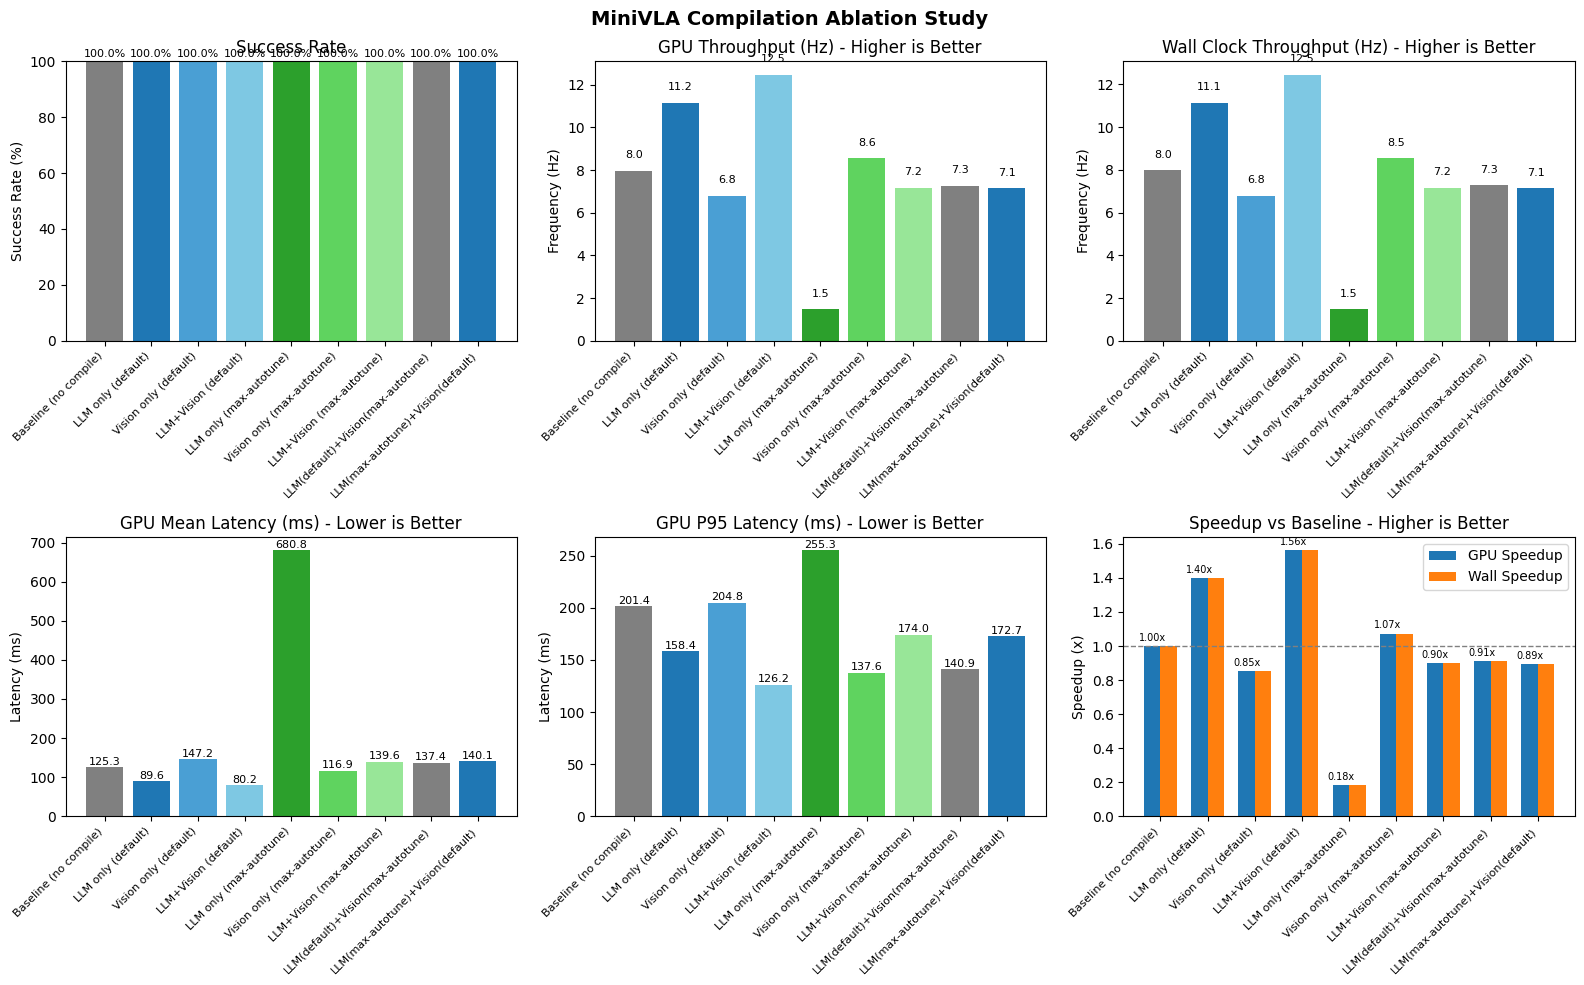

/pub/scratch/aagouzoul/tmp/ipykernel_3483191/4127608138.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax_gpu.boxplot(gpu_data, labels=gpu_labels, patch_artist=True)
/pub/scratch/aagouzoul/tmp/ipykernel_3483191/4127608138.py:130: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax_wall.boxplot(wall_data, labels=wall_labels, patch_artist=True)


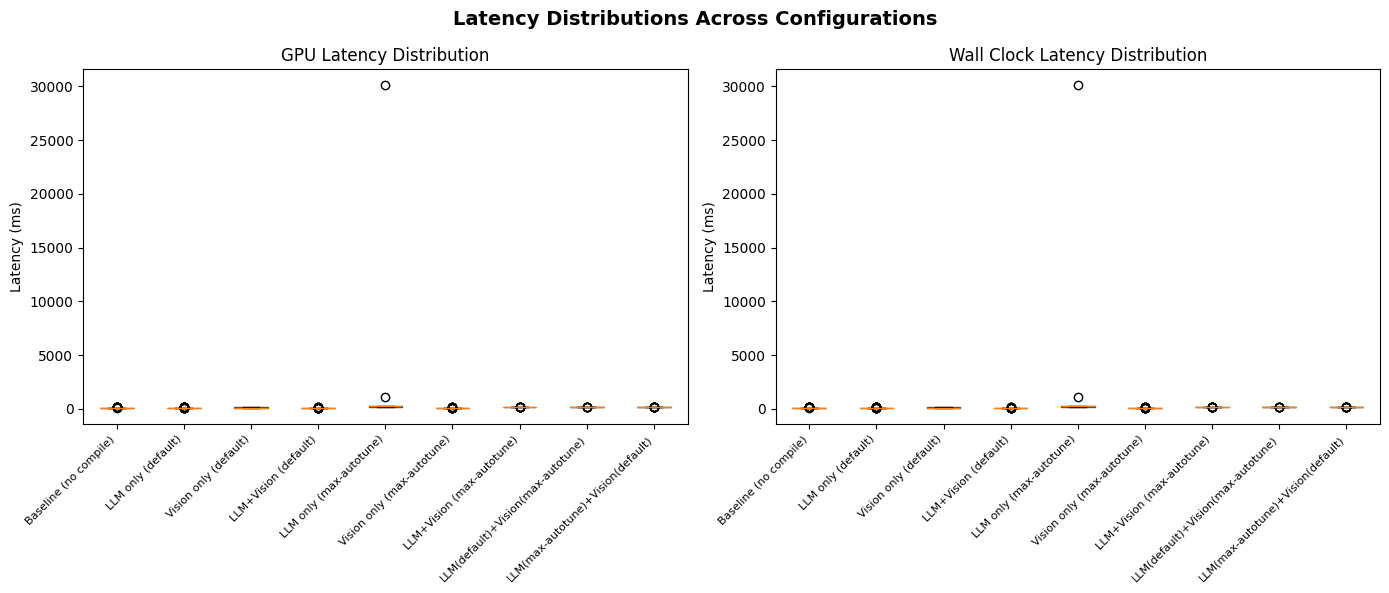

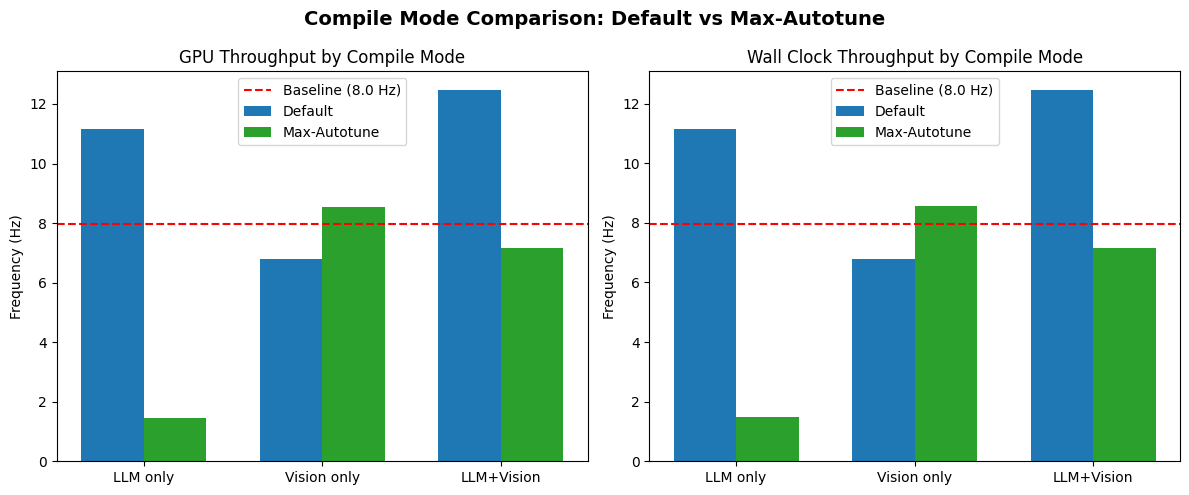

In [11]:
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("MiniVLA Compilation Ablation Study", fontsize=14, fontweight="bold")

labels = [r["label"] for r in ablation_results]
x = np.arange(len(labels))

# Color scheme: baseline=gray, default=blue shades, max-autotune=green shades
colors = ["#808080", "#1f77b4", "#4a9fd4", "#7ec8e3", "#2ca02c", "#5fd35f", "#98e698"]

# 1. Success Rate
ax1 = axes[0, 0]
success_rates = [r["success_rate"] * 100 for r in ablation_results]
bars1 = ax1.bar(x, success_rates, color=colors)
ax1.set_ylabel("Success Rate (%)")
ax1.set_title("Success Rate")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
ax1.set_ylim(0, 100)
for bar, val in zip(bars1, success_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{val:.1f}%", 
             ha="center", va="bottom", fontsize=8)

# 2. GPU Hz (Throughput)
ax2 = axes[0, 1]
gpu_hz = [r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0 for r in ablation_results]
bars2 = ax2.bar(x, gpu_hz, color=colors)
ax2.set_ylabel("Frequency (Hz)")
ax2.set_title("GPU Throughput (Hz) - Higher is Better")
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
for bar, val in zip(bars2, gpu_hz):
    if val > 0:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{val:.1f}", 
                 ha="center", va="bottom", fontsize=8)

# 3. Wall Hz (Throughput)
ax3 = axes[0, 2]
wall_hz = [r["wall_stats"].get("hz", 0) for r in ablation_results]
bars3 = ax3.bar(x, wall_hz, color=colors)
ax3.set_ylabel("Frequency (Hz)")
ax3.set_title("Wall Clock Throughput (Hz) - Higher is Better")
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
for bar, val in zip(bars3, wall_hz):
    if val > 0:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{val:.1f}", 
                 ha="center", va="bottom", fontsize=8)

# 4. GPU Mean Latency
ax4 = axes[1, 0]
gpu_mean = [r["gpu_stats"].get("mean_ms", 0) if r["gpu_stats"] else 0 for r in ablation_results]
bars4 = ax4.bar(x, gpu_mean, color=colors)
ax4.set_ylabel("Latency (ms)")
ax4.set_title("GPU Mean Latency (ms) - Lower is Better")
ax4.set_xticks(x)
ax4.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
for bar, val in zip(bars4, gpu_mean):
    if val > 0:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{val:.1f}", 
                 ha="center", va="bottom", fontsize=8)

# 5. GPU P95 Latency
ax5 = axes[1, 1]
gpu_p95 = [r["gpu_stats"].get("p95_ms", 0) if r["gpu_stats"] else 0 for r in ablation_results]
bars5 = ax5.bar(x, gpu_p95, color=colors)
ax5.set_ylabel("Latency (ms)")
ax5.set_title("GPU P95 Latency (ms) - Lower is Better")
ax5.set_xticks(x)
ax5.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
for bar, val in zip(bars5, gpu_p95):
    if val > 0:
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f"{val:.1f}", 
                 ha="center", va="bottom", fontsize=8)

# 6. Speedup vs Baseline
ax6 = axes[1, 2]
baseline_gpu_mean = ablation_results[0]["gpu_stats"].get("mean_ms", 1) if ablation_results[0]["gpu_stats"] else 1
baseline_wall_mean = ablation_results[0]["wall_stats"].get("mean_ms", 1)

gpu_speedup = [baseline_gpu_mean / r["gpu_stats"].get("mean_ms", baseline_gpu_mean) 
               if r["gpu_stats"] and r["gpu_stats"].get("mean_ms", 0) > 0 else 1.0 
               for r in ablation_results]
wall_speedup = [baseline_wall_mean / r["wall_stats"].get("mean_ms", baseline_wall_mean) 
                if r["wall_stats"].get("mean_ms", 0) > 0 else 1.0 
                for r in ablation_results]

width = 0.35
bars6a = ax6.bar(x - width/2, gpu_speedup, width, label="GPU Speedup", color="#1f77b4")
bars6b = ax6.bar(x + width/2, wall_speedup, width, label="Wall Speedup", color="#ff7f0e")
ax6.axhline(y=1.0, color="gray", linestyle="--", linewidth=1)
ax6.set_ylabel("Speedup (x)")
ax6.set_title("Speedup vs Baseline - Higher is Better")
ax6.set_xticks(x)
ax6.set_xticklabels(labels, rotation=45, ha="right", fontsize=8)
ax6.legend(loc="upper right")
for bar, val in zip(bars6a, gpu_speedup):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{val:.2f}x", 
             ha="center", va="bottom", fontsize=7)

plt.tight_layout()
plt.savefig("ablation_results.png", dpi=150, bbox_inches="tight")
plt.show()

# %%
# Latency distribution plots (box plots)
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle("Latency Distributions Across Configurations", fontsize=14, fontweight="bold")

# GPU latency distributions
ax_gpu = axes2[0]
gpu_data = [r["all_policy_gpu_ms"] for r in ablation_results if r["all_policy_gpu_ms"]]
gpu_labels = [r["label"] for r in ablation_results if r["all_policy_gpu_ms"]]
if gpu_data:
    bp1 = ax_gpu.boxplot(gpu_data, labels=gpu_labels, patch_artist=True)
    for patch, color in zip(bp1["boxes"], colors[:len(gpu_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax_gpu.set_ylabel("Latency (ms)")
    ax_gpu.set_title("GPU Latency Distribution")
    ax_gpu.tick_params(axis="x", rotation=45)
    for label in ax_gpu.get_xticklabels():
        label.set_ha("right")
        label.set_fontsize(8)

# Wall latency distributions
ax_wall = axes2[1]
wall_data = [r["all_policy_wall_ms"] for r in ablation_results]
wall_labels = [r["label"] for r in ablation_results]
bp2 = ax_wall.boxplot(wall_data, labels=wall_labels, patch_artist=True)
for patch, color in zip(bp2["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax_wall.set_ylabel("Latency (ms)")
ax_wall.set_title("Wall Clock Latency Distribution")
ax_wall.tick_params(axis="x", rotation=45)
for label in ax_wall.get_xticklabels():
    label.set_ha("right")
    label.set_fontsize(8)

plt.tight_layout()
plt.savefig("ablation_latency_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

# %%
# Grouped comparison: Default vs Max-Autotune for each compile option
fig3, axes3 = plt.subplots(1, 2, figsize=(12, 5))
fig3.suptitle("Compile Mode Comparison: Default vs Max-Autotune", fontsize=14, fontweight="bold")

compile_options = ["LLM only", "Vision only", "LLM+Vision"]
x_comp = np.arange(len(compile_options))
width = 0.35

# Extract data for comparison
default_gpu_hz = [ablation_results[1]["gpu_stats"].get("hz", 0),  # LLM only (default)
                  ablation_results[2]["gpu_stats"].get("hz", 0),  # Vision only (default)
                  ablation_results[3]["gpu_stats"].get("hz", 0)]  # LLM+Vision (default)

maxauto_gpu_hz = [ablation_results[4]["gpu_stats"].get("hz", 0),  # LLM only (max-autotune)
                  ablation_results[5]["gpu_stats"].get("hz", 0),  # Vision only (max-autotune)
                  ablation_results[6]["gpu_stats"].get("hz", 0)]  # LLM+Vision (max-autotune)

default_wall_hz = [ablation_results[1]["wall_stats"].get("hz", 0),
                   ablation_results[2]["wall_stats"].get("hz", 0),
                   ablation_results[3]["wall_stats"].get("hz", 0)]

maxauto_wall_hz = [ablation_results[4]["wall_stats"].get("hz", 0),
                   ablation_results[5]["wall_stats"].get("hz", 0),
                   ablation_results[6]["wall_stats"].get("hz", 0)]

baseline_hz = ablation_results[0]["gpu_stats"].get("hz", 0) if ablation_results[0]["gpu_stats"] else 0
baseline_wall_hz = ablation_results[0]["wall_stats"].get("hz", 0)

# GPU Hz comparison
ax_c1 = axes3[0]
bars_c1a = ax_c1.bar(x_comp - width/2, default_gpu_hz, width, label="Default", color="#1f77b4")
bars_c1b = ax_c1.bar(x_comp + width/2, maxauto_gpu_hz, width, label="Max-Autotune", color="#2ca02c")
ax_c1.axhline(y=baseline_hz, color="red", linestyle="--", linewidth=1.5, label=f"Baseline ({baseline_hz:.1f} Hz)")
ax_c1.set_ylabel("Frequency (Hz)")
ax_c1.set_title("GPU Throughput by Compile Mode")
ax_c1.set_xticks(x_comp)
ax_c1.set_xticklabels(compile_options)
ax_c1.legend()

# Wall Hz comparison
ax_c2 = axes3[1]
bars_c2a = ax_c2.bar(x_comp - width/2, default_wall_hz, width, label="Default", color="#1f77b4")
bars_c2b = ax_c2.bar(x_comp + width/2, maxauto_wall_hz, width, label="Max-Autotune", color="#2ca02c")
ax_c2.axhline(y=baseline_wall_hz, color="red", linestyle="--", linewidth=1.5, label=f"Baseline ({baseline_wall_hz:.1f} Hz)")
ax_c2.set_ylabel("Frequency (Hz)")
ax_c2.set_title("Wall Clock Throughput by Compile Mode")
ax_c2.set_xticks(x_comp)
ax_c2.set_xticklabels(compile_options)
ax_c2.legend()

plt.tight_layout()
plt.savefig("ablation_mode_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Print final summary table
print("\n" + "=" * 100)
print("FINAL ABLATION SUMMARY")
print("=" * 100)
print(f"\n{'Configuration':<35} {'Success Rate':>12} {'GPU Hz':>10} {'Wall Hz':>10} {'GPU Speedup':>12} {'Wall Speedup':>12}")
print("-" * 100)

for i, r in enumerate(ablation_results):
    gpu_hz = r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0
    wall_hz = r["wall_stats"].get("hz", 0)
    gpu_spd = gpu_speedup[i]
    wall_spd = wall_speedup[i]
    print(f"{r['label']:<35} {r['success_rate']*100:>11.1f}% {gpu_hz:>10.2f} {wall_hz:>10.2f} {gpu_spd:>11.2f}x {wall_spd:>11.2f}x")

print("=" * 100)

# Best configuration
best_gpu_idx = np.argmax(gpu_hz_arr := [r["gpu_stats"].get("hz", 0) if r["gpu_stats"] else 0 for r in ablation_results])
best_wall_idx = np.argmax(wall_hz_arr := [r["wall_stats"].get("hz", 0) for r in ablation_results])

print(f"\nBest GPU throughput: {ablation_results[best_gpu_idx]['label']} ({gpu_hz_arr[best_gpu_idx]:.2f} Hz)")
print(f"Best Wall throughput: {ablation_results[best_wall_idx]['label']} ({wall_hz_arr[best_wall_idx]:.2f} Hz)")


FINAL ABLATION SUMMARY

Configuration                       Success Rate     GPU Hz    Wall Hz  GPU Speedup Wall Speedup
----------------------------------------------------------------------------------------------------
Baseline (no compile)                     100.0%       7.98       7.97        1.00x        1.00x
LLM only (default)                        100.0%      11.16      11.15        1.40x        1.40x
Vision only (default)                     100.0%       6.79       6.79        0.85x        0.85x
LLM+Vision (default)                      100.0%      12.47      12.46        1.56x        1.56x
LLM only (max-autotune)                   100.0%       1.47       1.47        0.18x        0.18x
Vision only (max-autotune)                100.0%       8.55       8.55        1.07x        1.07x
LLM+Vision (max-autotune)                 100.0%       7.16       7.16        0.90x        0.90x
LLM(default)+Vision(max-autotune)         100.0%       7.28       7.27        0.91x        0.91x
L

: 

# ABOVE RESULTS WERE WITH COMPILE ON VB DIRECTLY, CONTRARY TO BEFORE WHERE IT WAS APPLIED SEPARATELY